# Active Subspace Analysis Notebook for NACA0012 Airfoil Design

**DESCRIPTION**

This data set comes from a simulation of the NACA0012 airfoil. The inputs are parameters of the free-form deformation boxes for the airfoil geometry. The outputs are the lift and drag of the wing. Gradients are available from an adjoint solver. All simulations are performed with [SU2](http://su2.stanford.edu/).

**INPUTS (18)**

Variable | Lower bound | Upper bound | Density
--- | --- | --- | ---
x1-x18 | -0.01 | 0.01 | Uniform

**OUTPUTS (2)**

Variable | Description
--- | --- 
Lift | The lift of the airfoil.
Drag | The drag of the airfoil.

**REFERENCES**

+ Lukaczyk, Palacios, Alonso, and Constantine. [Active Subspaces for Shape Optimization](http://arc.aiaa.org/doi/abs/10.2514/6.2014-1171)
+ Constantine, Dow, and Wang. [Active Subspace Methods in Theory and Practice: Applications to Kriging Surfaces](http://epubs.siam.org/doi/abs/10.1137/130916138)

**CONTACT**

Questions or comments? Contact [Paul Constantine](mailto:pconstan@mines.edu)


In [1]:
import numpy as np
import pandas as pn
import active_subspaces as ac
%matplotlib inline

Import the data set. Distinguish inputs (X), outputs (F), and gradients (G).

In [2]:
df = pn.DataFrame.from_csv('NACA0012.txt')
data = df.as_matrix()
X = data[:,:18]
F = data[:,18:20]
G_lift = data[:,20:38]
G_drag = data[:,38:]
M,m = X.shape
labels = df.keys()
out_labels = labels[18:20]

Normalize the inputs to the interval [-1,1].

In [3]:
xl = -0.01*np.ones((1,m))
xu = 0.01*np.ones((1,m))
XX = ac.utils.misc.BoundedNormalizer(xl,xu).normalize(X)

Choose the output of interest.

In [4]:
out_index = 1 # either 0 (lift) or 1 (drag)
f = F[:,out_index]
if out_index == 0:
    G = G_lift
else:
    G = G_drag
out_label = out_labels[out_index]

Compute the active subspace.

In [5]:
k = 6 # number of eigenvalues 
ss = ac.subspaces.Subspaces()
ss.compute(df=G,nboot=200)

Plot eigenvalues and subspace errors.

/home/ryhoward/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


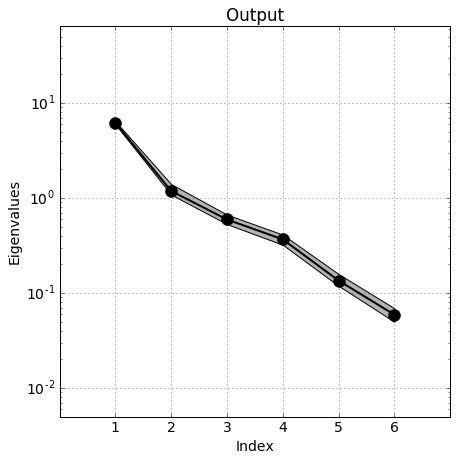

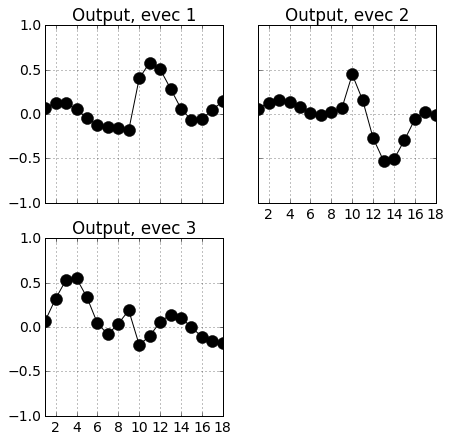

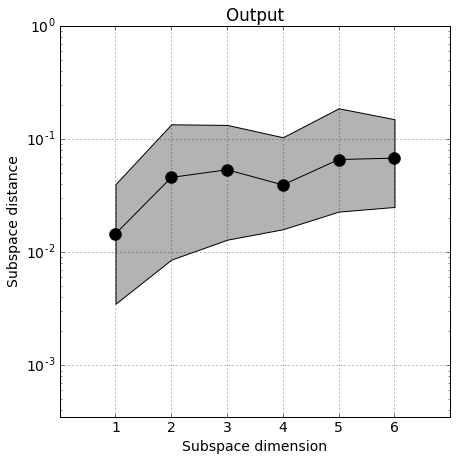

In [6]:
ac.utils.plotters.eigenvalues(ss.eigenvalues[:k],e_br=ss.e_br[:k,:])
ac.utils.plotters.eigenvectors(ss.eigenvectors[:,:3])
ac.utils.plotters.subspace_errors(ss.sub_br[:k,:])

One- and two-d sufficient summary plots.

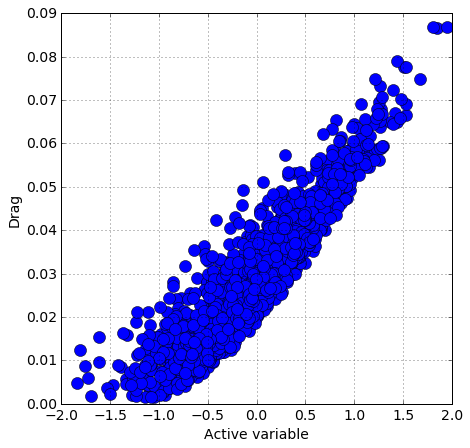

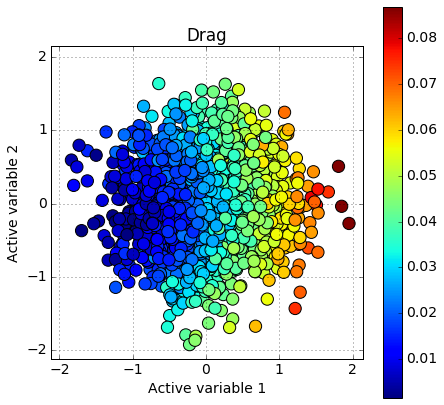

In [7]:
ss.partition(2)
y = np.dot(XX,ss.W1)
ac.utils.plotters.sufficient_summary(y,f,out_label=out_label)